# Mosaic Integration of RNA+ADT+ATAC

In this tutorial, we demonstrate how to integrate a mosaic dataset consisting of RNA, ADT, and ATAC data. We will also walk through the inference process and the outputs generated by MIDAS.

## Step 1: Downloading the Demo Data and Model

In [ ]:
from scmidas.data import download_data, download_models
download_data('teadog_mosaic_mtx', './')
download_models('teadog_mosaic_mtx', './')

## Step 2: Setting Up the Environment

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'

from scmidas.config import load_config
from scmidas.model import MIDAS
import lightning as L
from lightning import seed_everything

import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score

sc.set_figure_params(figsize=(4, 4))
seed_everything(42)

Seed set to 42


42

## Step 3: Configuring the Model

In this step, we configure the model for our dataset. Since we define the ATAC data as a Bernoulli distribution, we set 'binarize' in MIDAS.

In [3]:
configs = load_config() # refer to Tutotrials/Advanced/Development Instructions for details
configs['num_workers'] = 2

INFO:root:The model is initialized with the default configurations.


In [4]:
task = 'teadog_mosaic_mtx'
transform = {'atac':'binarize'}
model = MIDAS.configure_data_from_dir(configs, './dataset/'+task+'/data', transform=transform)

INFO:root:Input data: 
         #CELL    #ATAC    #RNA   #ADT  #VALID_RNA  #VALID_ADT
BATCH 0   7325  31243.0  4047.0    NaN      3809.0         NaN
BATCH 1   7137  31243.0     NaN  213.0         NaN        45.0
BATCH 2   7361      NaN  4047.0  213.0      3862.0       208.0
BATCH 3   9527  31243.0  4047.0  213.0      3751.0       208.0


## Step 4: Training the Model

Instead of training the model from scratch, we will utilize a pre-trained model for this demonstration.

In [ ]:
model.load_checkpoint(f'./saved_models/{task}.pt')

In [ ]:
# Train from scratch:
# trainer = L.Trainer(max_epochs=2000)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
# trainer.fit(model=model)

## Step 5: Prediction

In this step, we explore the various outputs generated by MIDAS.

In [ ]:
# Load labels.
label = []
batch_id = []
for i in ['w1', 'w6', 'lll_ctrl', 'dig_stim']:
    label.append(pd.read_csv('./dataset/'+task+'/label/%s.csv'%i, index_col=0).values.flatten())
    batch_id.append([i]*len(label[-1]))
labels = np.concatenate(label)
batch_id = np.concatenate(batch_id)

### Joint Embeddings

In [ ]:
# Load joint latent embeddings.
# If you prefer to save the joint latent embeddings to disk, 
# you can set `save_dir` in the scmidas.model.MIDAS.predict() method 
# and use scmidas.utils.load_predicted() to load the embeddings later.
joint_embeddings = model.predict(joint_latent=True)

The joint embeddings consist of two components: biological information $c$ and technical information $u$.

To analyze them, we split the embeddings and visualize them separately.

/root/anaconda3/envs/scmidas3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
... storing 'batch' as categorical
... storing 'label' as categorical


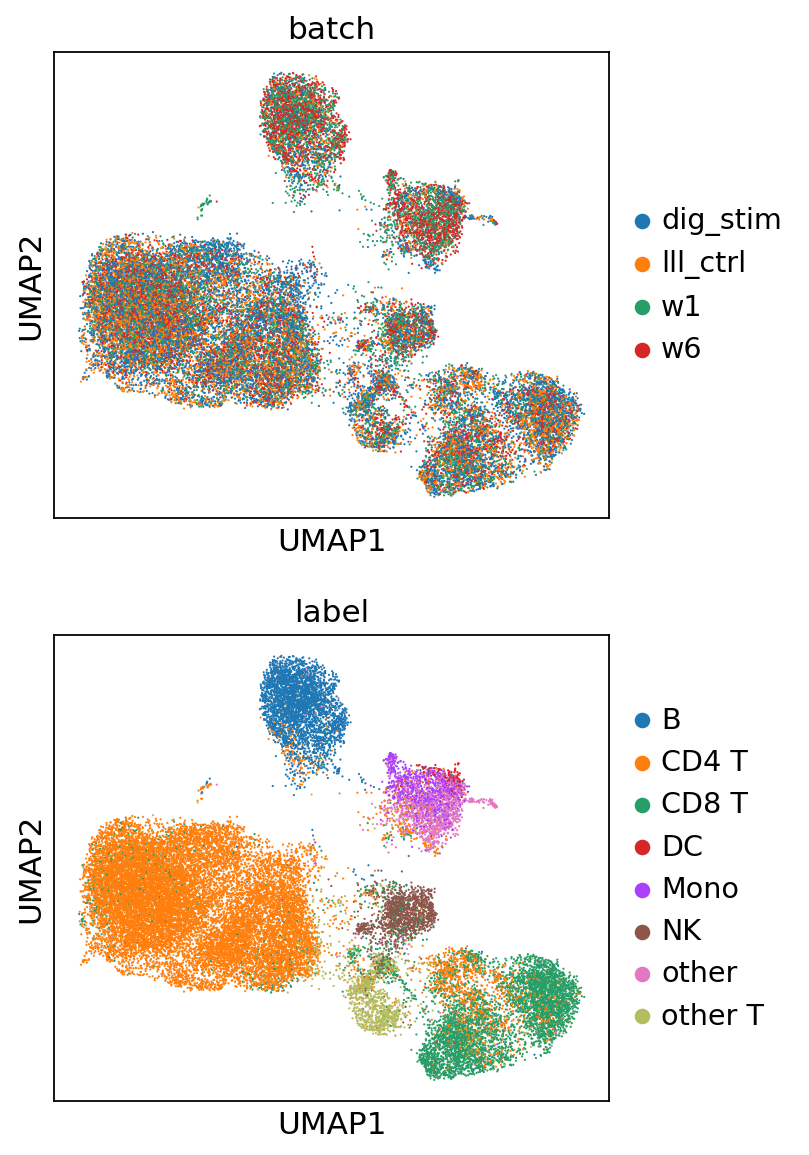

... storing 'batch' as categorical
... storing 'label' as categorical


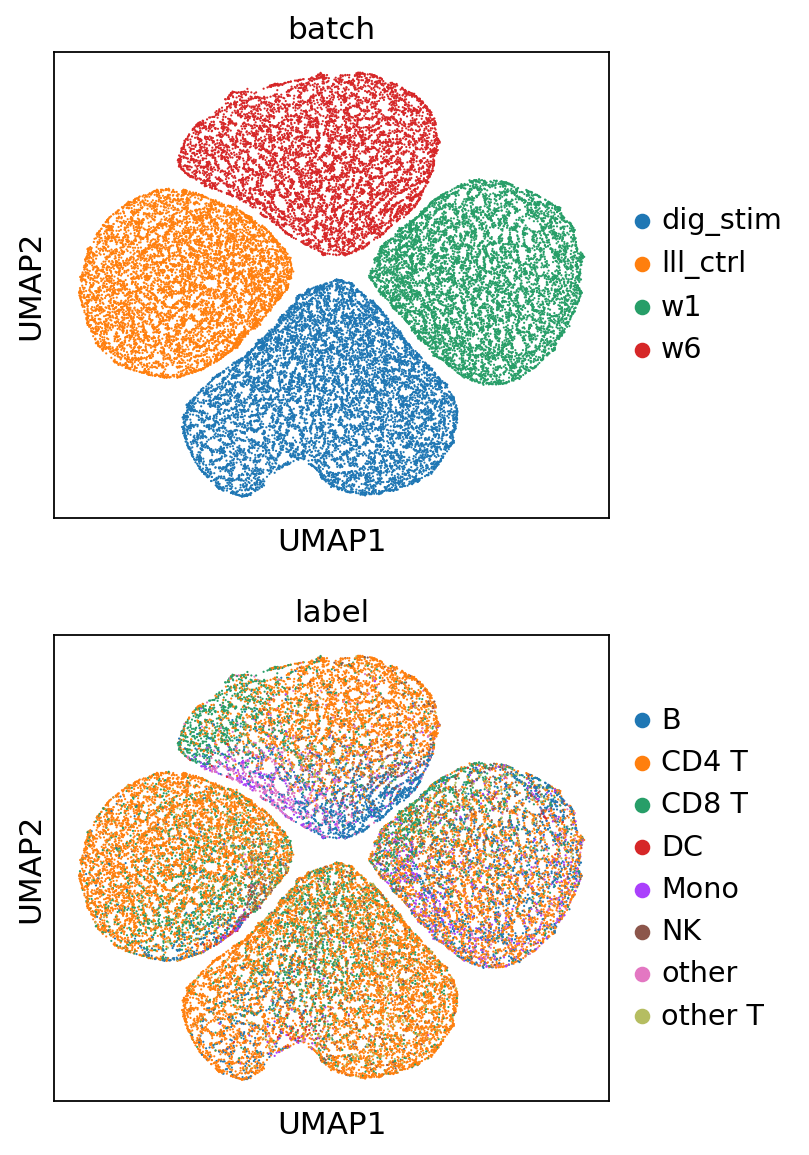

In [9]:
adata_bio = sc.AnnData(joint_embeddings['z']['joint'][:, :model.dim_c])
adata_tech = sc.AnnData(joint_embeddings['z']['joint'][:, model.dim_c:])

adata_bio.obs['batch'] = batch_id
adata_bio.obs['label'] = labels
adata_tech.obs['batch'] = batch_id
adata_tech.obs['label'] = labels

for adata in [adata_bio, adata_tech]:
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)    
    sc.pp.subsample(adata, fraction=1) #shuffle
    sc.pl.umap(adata, color=['batch', 'label'], ncols=1)

### Modality Embeddings

MIDAS can generate embeddings for each modality. Here, we check the alignment among modalities by visualizing them with UMAP.

In [ ]:
mod_embeddings = model.predict(mod_latent=True, group_by='batch')

In [ ]:
batch_names = ['w1', 'w6', 'lll_ctrl', 'dig_stim']
adata_list = []
for i in range(model.dims_s['joint']):
    for m in model.mods+['joint']:
        if m in mod_embeddings[i]['z']:
            adata = sc.AnnData(mod_embeddings[i]['z'][m][:, :model.dim_c])
            adata.obs['batch'] = batch_names[i]
            adata.obs['modality'] = m
            adata.obs['label'] = label[i]
            adata_list.append(adata)
adata_mod_concat = sc.concat(adata_list)
for i in adata_mod_concat.obs:
    adata_mod_concat.obs[i] = adata_mod_concat.obs[i].astype('category')
sc.pp.neighbors(adata_mod_concat)
sc.pp.subsample(adata_mod_concat, fraction=1) # shuffle
sc.tl.umap(adata_mod_concat)

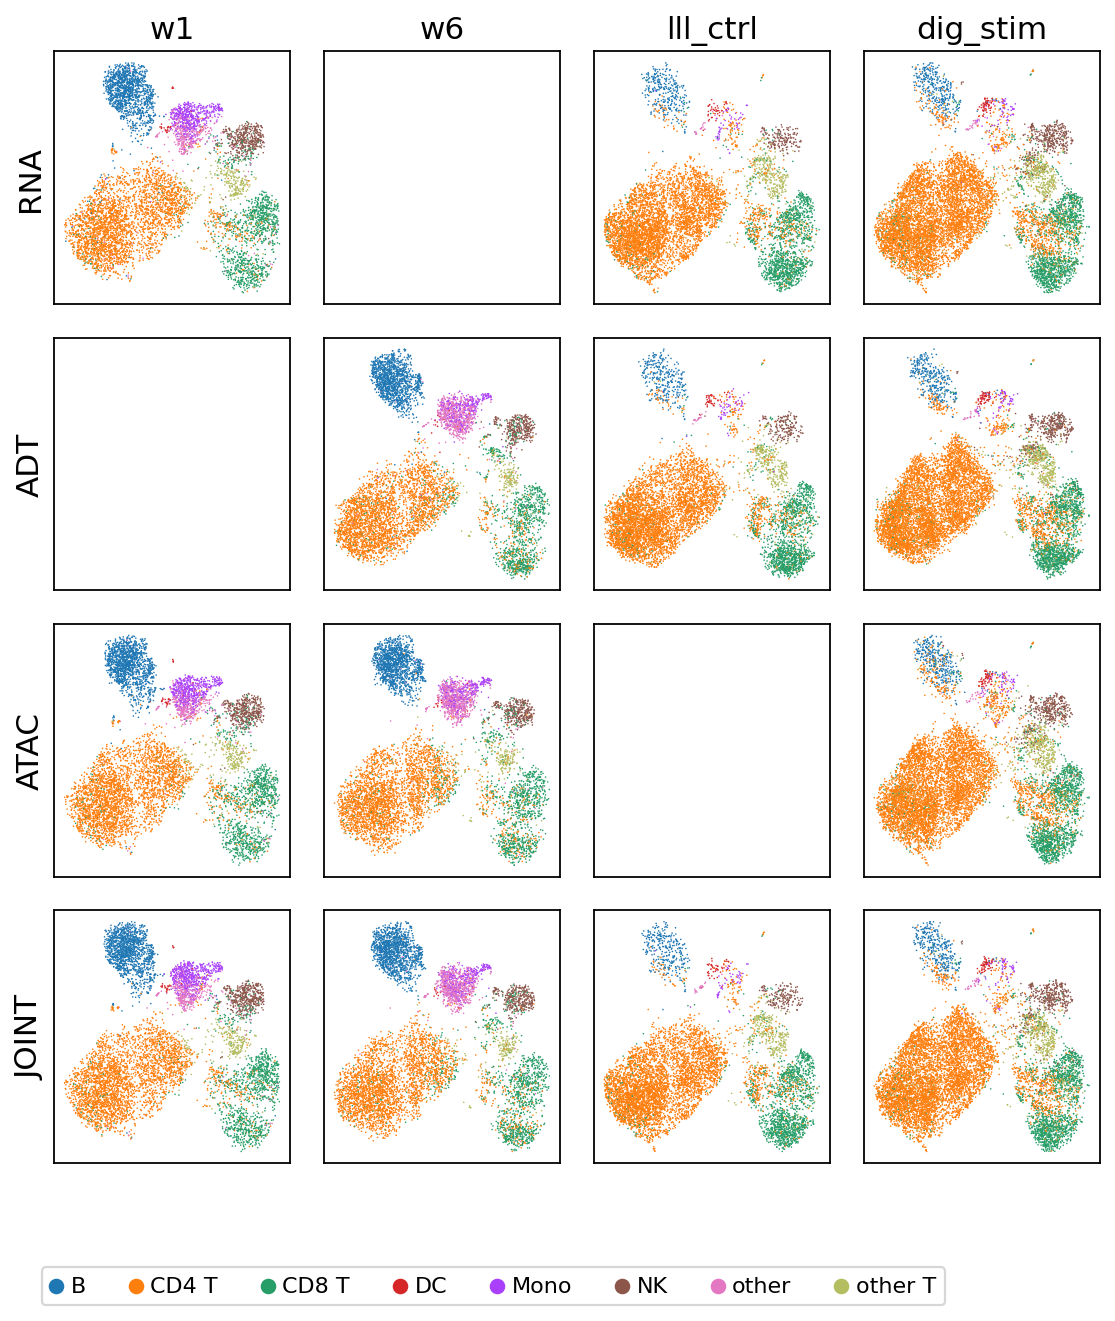

In [16]:
# setup figure
nrows = len(model.mods) + 1
ncols = model.dims_s['joint']
point_size = 2

fig, ax = plt.subplots(nrows, ncols, figsize=[2 * ncols, 2 * nrows])

# set up the name of modalities and batch
mod_names = model.mods + ['joint']

# iteratively scatter the data
for i, mod in enumerate(mod_names):
    for b in range(model.dims_s['joint']):
        # filter data
        adata = adata_mod_concat[
            (adata_mod_concat.obs['modality'] == mod) & 
            (adata_mod_concat.obs['batch'] == batch_names[b])
        ].copy()
        if len(adata):
            sc.pl.umap(adata, color='label', show=False, ax=ax[i, b], s=point_size)
            ax[i, b].get_legend().set_visible(False)
            handles, labels_ = ax[i, b].get_legend_handles_labels()
        ax[i, b].set_xticks([])
        ax[i, b].set_yticks([])
        ax[i, b].set_xlabel('')
        if b==0:
            ax[i, b].set_ylabel(mod.upper())
        else:
            ax[i, b].set_ylabel('')
        if i==0:
            ax[i, b].set_title(batch_names[b])
        else:
            ax[i, b].set_title('')
# create global legend
fig.legend(handles, labels_, loc='center', bbox_to_anchor=(0.5, -0.02), ncol=len(labels_), fontsize=10)

# adjust the figure
plt.tight_layout(rect=[0.1, 0.05, 1, 1])
plt.show()

### Imputed Counts

Here, we retrieve the imputed ADT from batch 0, RNA from batch 1, and ATAC from batch 2. Then we calculate the similarity between the predicted counts and the ground-truth counts.

In [ ]:
from scipy.io import mmread

In [ ]:
imputed = model.predict(impute=True)

In [ ]:
ref_adt = mmread('./dataset/'+task+'/ref_data/batch_0_adt.mtx').toarray()
id = imputed['s']['joint'].flatten()==0
print('Pearson\'s r for ADT (BATCH 0)', pearsonr(ref_adt.reshape(-1), imputed['x_impt']['adt'][id].reshape(-1))[0])

Pearson's r for ADT (BATCH 0) 0.3346994980482338


In [ ]:
ref_rna = mmread('./dataset/'+task+'/ref_data/batch_1_rna.mtx').toarray()
id = imputed['s']['joint'].flatten()==1
print('Pearson\'s r for RNA (BATCH 1)', pearsonr(ref_rna.reshape(-1), imputed['x_impt']['rna'][id].reshape(-1))[0])

Pearson's r for RNA (BATCH 1) 0.8371097840779427


In [24]:
ref_atac = mmread('./dataset/'+task+'/ref_data/batch_2_atac.mtx').toarray()
ref_atac = np.where(ref_atac>0.5, 1, 0)
id = imputed['s']['joint'].flatten()==2
print('AUROC for ATAC (BATCH 2)', roc_auc_score(ref_atac.reshape(-1), imputed['x_impt']['atac'][id].reshape(-1)))

AUROC for ATAC (BATCH 2) 0.770168015616374


### Batch-corrected Counts

By using the `standard noise`, we can generate the batch-corrected data. To validate the batch effect in the predicted multi-modalities counts, we use PCA+WNN to gain the joint embeddings for them. First of all, we load the batch-corrected counts.

In [ ]:
batch_corrected_counts = model.predict(batch_correct=True)

To reduce computation time, we will randomly select a subset of samples for the analysis.

In [ ]:
select = np.random.choice(list(range(len(batch_corrected_counts['x_bc']['rna']))), 2000, replace=False)
select

Only the shared features will be used.
Save the data to CSV files for later use in R.

In [10]:
mask = {'rna':[], 'adt':[]}
for i in range(4):
    for m in ['rna', 'adt']:
        try:
            mask[m].append(pd.read_csv('./dataset/'+task+'/data/batch_%d/mask/%s.csv'%(i, m), index_col=0).values)
        except:
            pass
rna_ = pd.DataFrame(batch_corrected_counts['x_bc']['rna'][:, (np.sum(mask['rna'], axis=0)==3)[0]][select]).T
adt_ = pd.DataFrame(batch_corrected_counts['x_bc']['adt'][:, (np.sum(mask['adt'], axis=0)==3)[0]][select]).T
atac_ = pd.DataFrame(batch_corrected_counts['x_bc']['atac'][select]).T
rna_.to_csv('./temp_rna.csv', index=True)
adt_.to_csv('./temp_adt.csv', index=True)
atac_.to_csv('./temp_atac.csv', index=True)

Set up the R environment.

In [ ]:
import os
os.environ["R_HOME"] = "/usr/lib/R"
os.environ["R_LIBS_USER"] = "/usr/lib/R/lib"
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
importr('Seurat')
importr('SeuratDisk')
importr('dplyr')
importr('Signac')

PCA+WNN

In [ ]:
ro.r('''
rna <- read.csv('./temp_rna.csv', header=TRUE, row.names=1)
adt <- read.csv('./temp_adt.csv', header=TRUE, row.names=1)
atac <- read.csv('./temp_atac.csv', header=TRUE, row.names=1)
obj <- CreateSeuratObject(counts = rna, assay = "rna")
obj[["adt"]] <- CreateAssayObject(counts = adt)
obj[["atac"]] <- CreateAssayObject(counts = atac)
obj <- subset(obj, subset = nCount_atac > 0 & nCount_rna > 0 & nCount_adt > 0)
print(obj)
DefaultAssay(obj) <- 'atac'
obj <-  RunTFIDF(obj) %>%
        FindTopFeatures(min.cutoff = "q25") %>%
        RunSVD(reduction.name = "lsi")
print('finish atac')
DefaultAssay(obj) <- 'rna'
VariableFeatures(obj) <- rownames(obj)
obj <-  NormalizeData(obj) %>%
        # FindVariableFeatures(nfeatures = 2000) %>%
        ScaleData() %>%
        RunPCA(reduction.name = "pca_rna", verbose = F)
print('finish rna')
DefaultAssay(obj) <- 'adt'
VariableFeatures(obj) <- rownames(obj)
obj <-  NormalizeData(obj, normalization.method = "CLR", margin = 2) %>%
        ScaleData() %>%
        RunPCA(reduction.name = "pca_adt", verbose = F)
print('finish adt')
print('WNN ...')
obj <- FindMultiModalNeighbors(obj, list("lsi", "pca_rna", "pca_adt"), list(1:50, 1:50, 1:32))
obj <- RunUMAP(obj, nn.name = "weighted.nn", reduction.name = "umap")
''')

... storing 'label' as categorical
... storing 'batch' as categorical


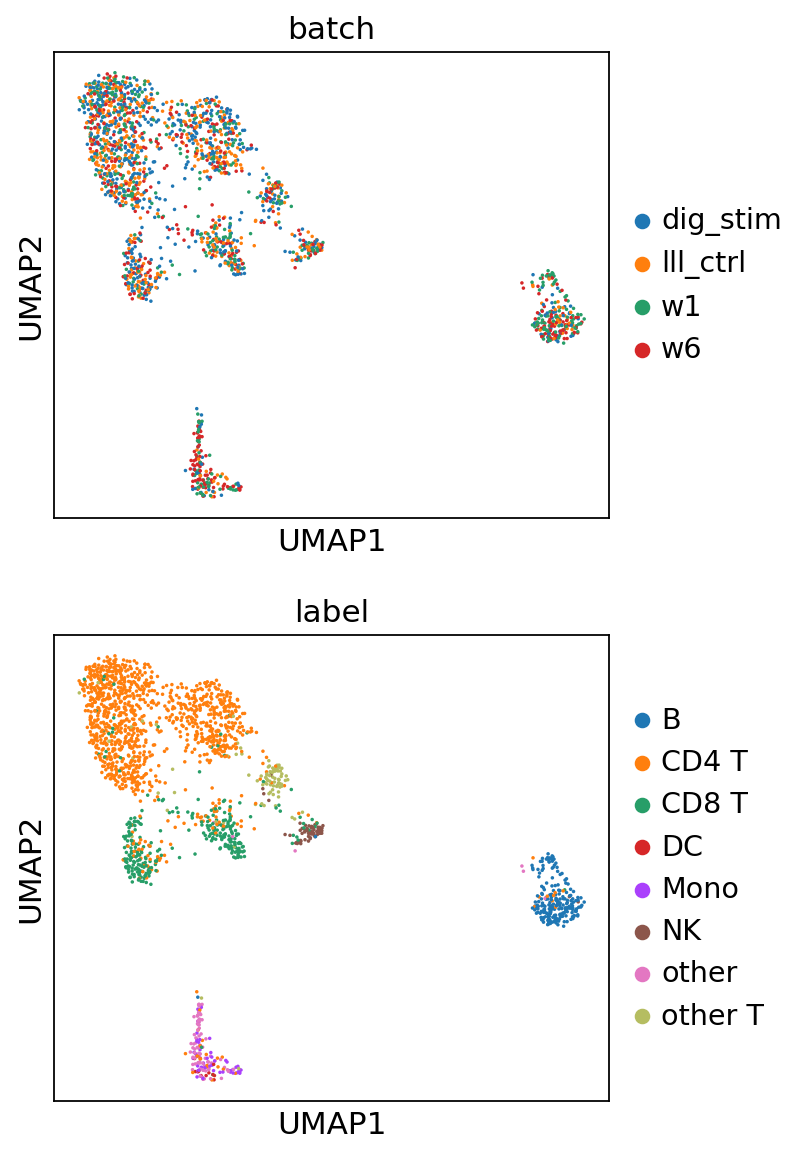

In [13]:
# Create an AnnData object with 'X' not being used, so we initialize it with all zeros
adata = sc.AnnData(np.zeros([2000, 1]))
adata.obs['label'] = labels[select]
adata.obs['batch'] = batch_id[select]
f = ro.r('''
     DimPlot(obj, reduction='umap')
     ''')
adata.obsm['umap'] = pd.DataFrame(f[0]).iloc[:2].T.values
# Shuffle
sc.pp.subsample(adata, fraction=1)
sc.pl.umap(adata, color=['batch', 'label'], ncols=1, size=10)